# ⚛️ H₂ VQE — Noisy Ansatz Comparison (Production API)

This notebook compares **ansatz families** for **H₂ VQE** under different
**noise channels**, using only the **packaged VQE API**.

We run **multi-seed noise statistics** and compare ansatzes by:

- Mean and standard deviation of the **energy error**:  ΔE = E_noisy − E_ref
- Mean and standard deviation of the **fidelity** vs a noiseless reference state
- Across a grid of **noise strengths**

Key entry point:

```python
from vqe.core import run_vqe_ansatz_comparison
```

## 1️⃣ Imports and configuration

In [9]:
import numpy as np

from vqe.core import run_vqe_ansatz_comparison

### Experiment defaults

- Molecule: **H₂**
- Optimizer: **Adam**
- Steps / stepsize: **50**, **0.2**
- Mapping: **Jordan–Wigner**
- Noise grid: **0.00 → 0.10**
- Seeds: **0 → 9**

$$\text{cost} \sim N_{\text{ansatz}} \times N_{\text{noise}} \times N_{\text{seeds}} \times N_{\text{steps}}$$

In [ ]:
molecule = "H2"
optimizer_name = "Adam"
mapping = "jordan_wigner"

steps = 50
stepsize = 0.2

noise_levels = np.arange(0.0, 0.11, 0.02)
seeds = np.arange(0, 10)

ansatzes = [
    "UCC-S",
    "UCC-D",
    "UCCSD",
    "Minimal",
    "RY-CZ",
    "TwoQubit-RY-CNOT",
    "StronglyEntanglingLayers",
]

print("Molecule:", molecule)
print("Optimizer:", optimizer_name)
print("Steps:", steps)
print("Stepsize:", stepsize)
print("Mapping:", mapping)
print("Noise levels:", noise_levels)
print("Seeds:", seeds)
print("Ansatzes:", ansatzes)

Molecule: H2
Optimizer: Adam
Steps: 50
Stepsize: 0.2
Mapping: jordan_wigner
Noise levels: [0.   0.02 0.04 0.06 0.08 0.1 ]
Seeds: [0]
Ansatzes: ['UCC-S', 'UCC-D', 'UCCSD', 'Minimal', 'RY-CZ', 'TwoQubit-RY-CNOT', 'StronglyEntanglingLayers']


## 2️⃣ Helper: simple robustness score

In [11]:
def auc_trapz(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    return float(np.trapz(y, x))


def summarise_noise_stats(result_dict):
    """
    Build a compact summary table from the output of
    run_vqe_ansatz_comparison(mode="noise_stats", ...).
    """
    x = np.asarray(result_dict["noise_levels"], dtype=float)
    rows = []
    for ans_name, data in result_dict["ansatzes"].items():
        deltaE_mean = np.asarray(data["deltaE_mean"], dtype=float)
        fid_mean = np.asarray(data["fidelity_mean"], dtype=float)

        rows.append(
            {
                "ansatz": ans_name,
                "AUC_deltaE": auc_trapz(x, np.abs(deltaE_mean)),
                "AUC_1_minus_fidelity": auc_trapz(x, 1.0 - fid_mean),
                "deltaE_at_max_noise": float(deltaE_mean[-1]),
                "fidelity_at_max_noise": float(fid_mean[-1]),
            }
        )

    rows = sorted(rows, key=lambda r: (r["AUC_deltaE"], r["AUC_1_minus_fidelity"]))
    return rows


def print_summary(rows, title):
    print("\n" + title)
    print("-" * len(title))
    header = (
        f"{'ansatz':<28s} "
        f"{'AUC|ΔE|':>12s} "
        f"{'AUC(1-F)':>12s} "
        f"{'ΔE@max':>12s} "
        f"{'F@max':>10s}"
    )
    print(header)
    print("-" * len(header))
    for r in rows:
        print(
            f"{r['ansatz']:<28s} "
            f"{r['AUC_deltaE']:>12.6f} "
            f"{r['AUC_1_minus_fidelity']:>12.6f} "
            f"{r['deltaE_at_max_noise']:>12.6f} "
            f"{r['fidelity_at_max_noise']:>10.4f}"
        )

## 3️⃣ Depolarizing noise: ansatz comparison (multi-seed)


🔹 Ansatz: UCC-S (optimizer=Adam, stepsize=0.2)
  🔹 Computing noiseless references per seed...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCC-S__Adam__VQE__noiseless__s0__ccd80ee1705e.json
  🔹 Sweeping noise levels...
Step 01/50: E = -1.116684 Ha
Step 02/50: E = -1.116407 Ha
Step 03/50: E = -1.111033 Ha
Step 04/50: E = -1.116496 Ha
Step 05/50: E = -1.114324 Ha
Step 06/50: E = -1.113355 Ha
Step 07/50: E = -1.115776 Ha
Step 08/50: E = -1.116588 Ha
Step 09/50: E = -1.115110 Ha
Step 10/50: E = -1.114695 Ha
Step 11/50: E = -1.115912 Ha
Step 12/50: E = -1.116684 Ha
Step 13/50: E = -1.116081 Ha
Step 14/50: E = -1.115420 Ha
Step 15/50: E = -1.115809 Ha
Step 16/50: E = -1.116550 Ha
Step 17/50: E = -1.116589 Ha
Step 18/50: E = -1.116068 Ha
Step 19/50: E = -1.115925 Ha
Step 20/50: E = -1.116355 Ha
Step 21/50: E = -1.116681 Ha
Step 22/50: E = -1.116491 Ha
Step 23/50: E = -1.116200 Ha
Step 24/50: E = -1.116301 Ha
Step 25/50: E = -1.116609 Ha
Step 26/50: E = 

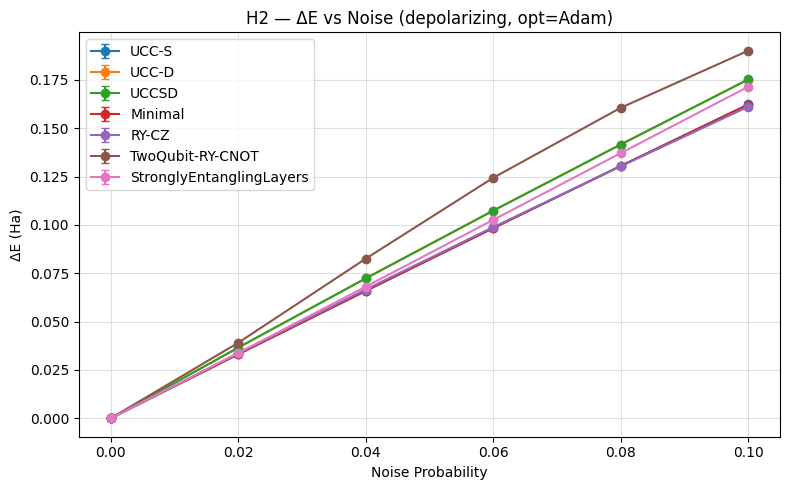

<Figure size 640x480 with 0 Axes>

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_noisy_ansatz_comparison_deltae_optAdam_noisedepolarizing.png


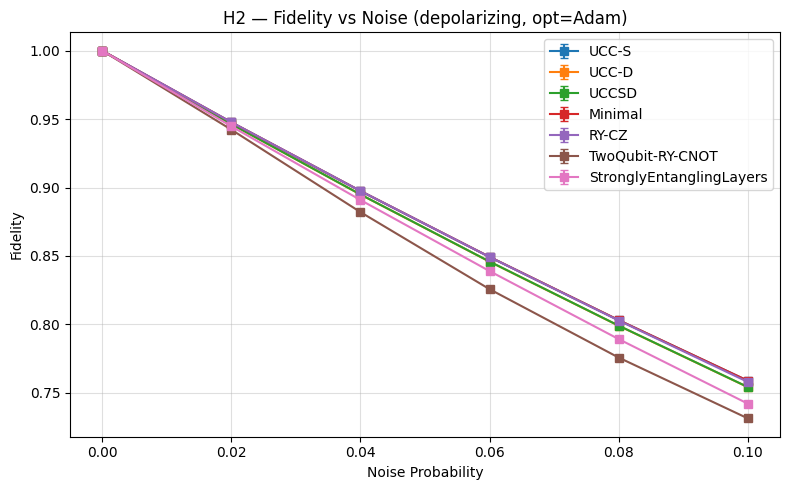

<Figure size 640x480 with 0 Axes>

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_noisy_ansatz_comparison_fidelity_optAdam_noisedepolarizing.png

Depolarizing noise — robustness summary
---------------------------------------
ansatz                            AUC|ΔE|     AUC(1-F)       ΔE@max      F@max
------------------------------------------------------------------------------
Minimal                          0.008178     0.012458     0.162243     0.7588
UCC-S                            0.008179     0.012468     0.162270     0.7588
RY-CZ                            0.008198     0.012476     0.161083     0.7579
StronglyEntanglingLayers         0.008545     0.013305     0.171439     0.7420
UCC-D                            0.008908     0.012740     0.175185     0.7541
UCCSD                            0.008909     0.012734     0.175203     0.7542
TwoQubit-RY-CNOT                 0.010029     0.014173     0.190073     0.7313


/tmp/ipykernel_103532/581287597.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y, x))


In [12]:
dep_results = run_vqe_ansatz_comparison(
    molecule=molecule,
    optimizer_name=optimizer_name,
    ansatzes=ansatzes,
    steps=steps,
    stepsize=stepsize,
    mode="noise_stats",
    noise_type="depolarizing",
    noise_levels=noise_levels,
    seeds=seeds,
    mapping=mapping,
    force=False,
    show=True,
    plot=True,
)

dep_summary = summarise_noise_stats(dep_results)
print_summary(dep_summary, title="Depolarizing noise — robustness summary")


## 4️⃣ Amplitude damping noise: ansatz comparison (multi-seed)

In [13]:
amp_results = run_vqe_ansatz_comparison(
    molecule=molecule,
    optimizer_name=optimizer_name,
    ansatzes=ansatzes,
    steps=steps,
    stepsize=stepsize,
    mode="noise_stats",
    noise_type="amplitude",
    noise_levels=noise_levels,
    seeds=seeds,
    mapping=mapping,
    force=False,
    show=True,
    plot=True,
)

amp_summary = summarise_noise_stats(amp_results)
print_summary(amp_summary, title="Amplitude damping — robustness summary")


🔹 Ansatz: UCC-S (optimizer=Adam, stepsize=0.2)
  🔹 Computing noiseless references per seed...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCC-S__Adam__VQE__noiseless__s0__ccd80ee1705e.json
  🔹 Sweeping noise levels...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCC-S__Adam__VQE__noisy__s0__17b428b4455d.json
    p_dep=0.00, p_amp=0.00: ΔE=0.000003 ± 0.000000, ⟨F⟩=0.9999 ± 0.0000
Step 01/50: E = -1.093296 Ha
Step 02/50: E = -1.092800 Ha
Step 03/50: E = -1.088581 Ha
Step 04/50: E = -1.093033 Ha
Step 05/50: E = -1.091582 Ha
Step 06/50: E = -1.090667 Ha
Step 07/50: E = -1.092645 Ha
Step 08/50: E = -1.093157 Ha
Step 09/50: E = -1.091886 Ha
Step 10/50: E = -1.091818 Ha
Step 11/50: E = -1.092915 Ha
Step 12/50: E = -1.093245 Ha
Step 13/50: E = -1.092543 Ha
Step 14/50: E = -1.092283 Ha
Step 15/50: E = -1.092876 Ha
Step 16/50: E = -1.093295 Ha
Step 17/50: E = -1.092982 Ha
Step 18/50: E = -1.092633 Ha
Step 19/50: E = 

KeyboardInterrupt: 